# 名词解释

* 全连接：用的网络全都是线性层，输入值和输出值都存在权重关系

* 卷积层：主要关注输入通道数、输出通道数、卷积核大小


In [1]:
import torch  

in_channels, out_channels = 5,10 # 输入通道数，输出通道数
width, height = 100,100 # 输入图片的宽和高
kernel_size = 3 # 卷积核大小
batch_size = 1 # 批量大小

input = torch.randn(batch_size,in_channels,width,height)

conv = torch.nn.Conv2d(in_channels,out_channels,kernel_size)

output = conv(input)

print(input.shape) # 1,5,100,100
print(output.shape) # 1,10,98,98
print(conv.weight.shape) # 10,5,3,3

torch.Size([1, 5, 100, 100])
torch.Size([1, 10, 98, 98])
torch.Size([10, 5, 3, 3])


# padding

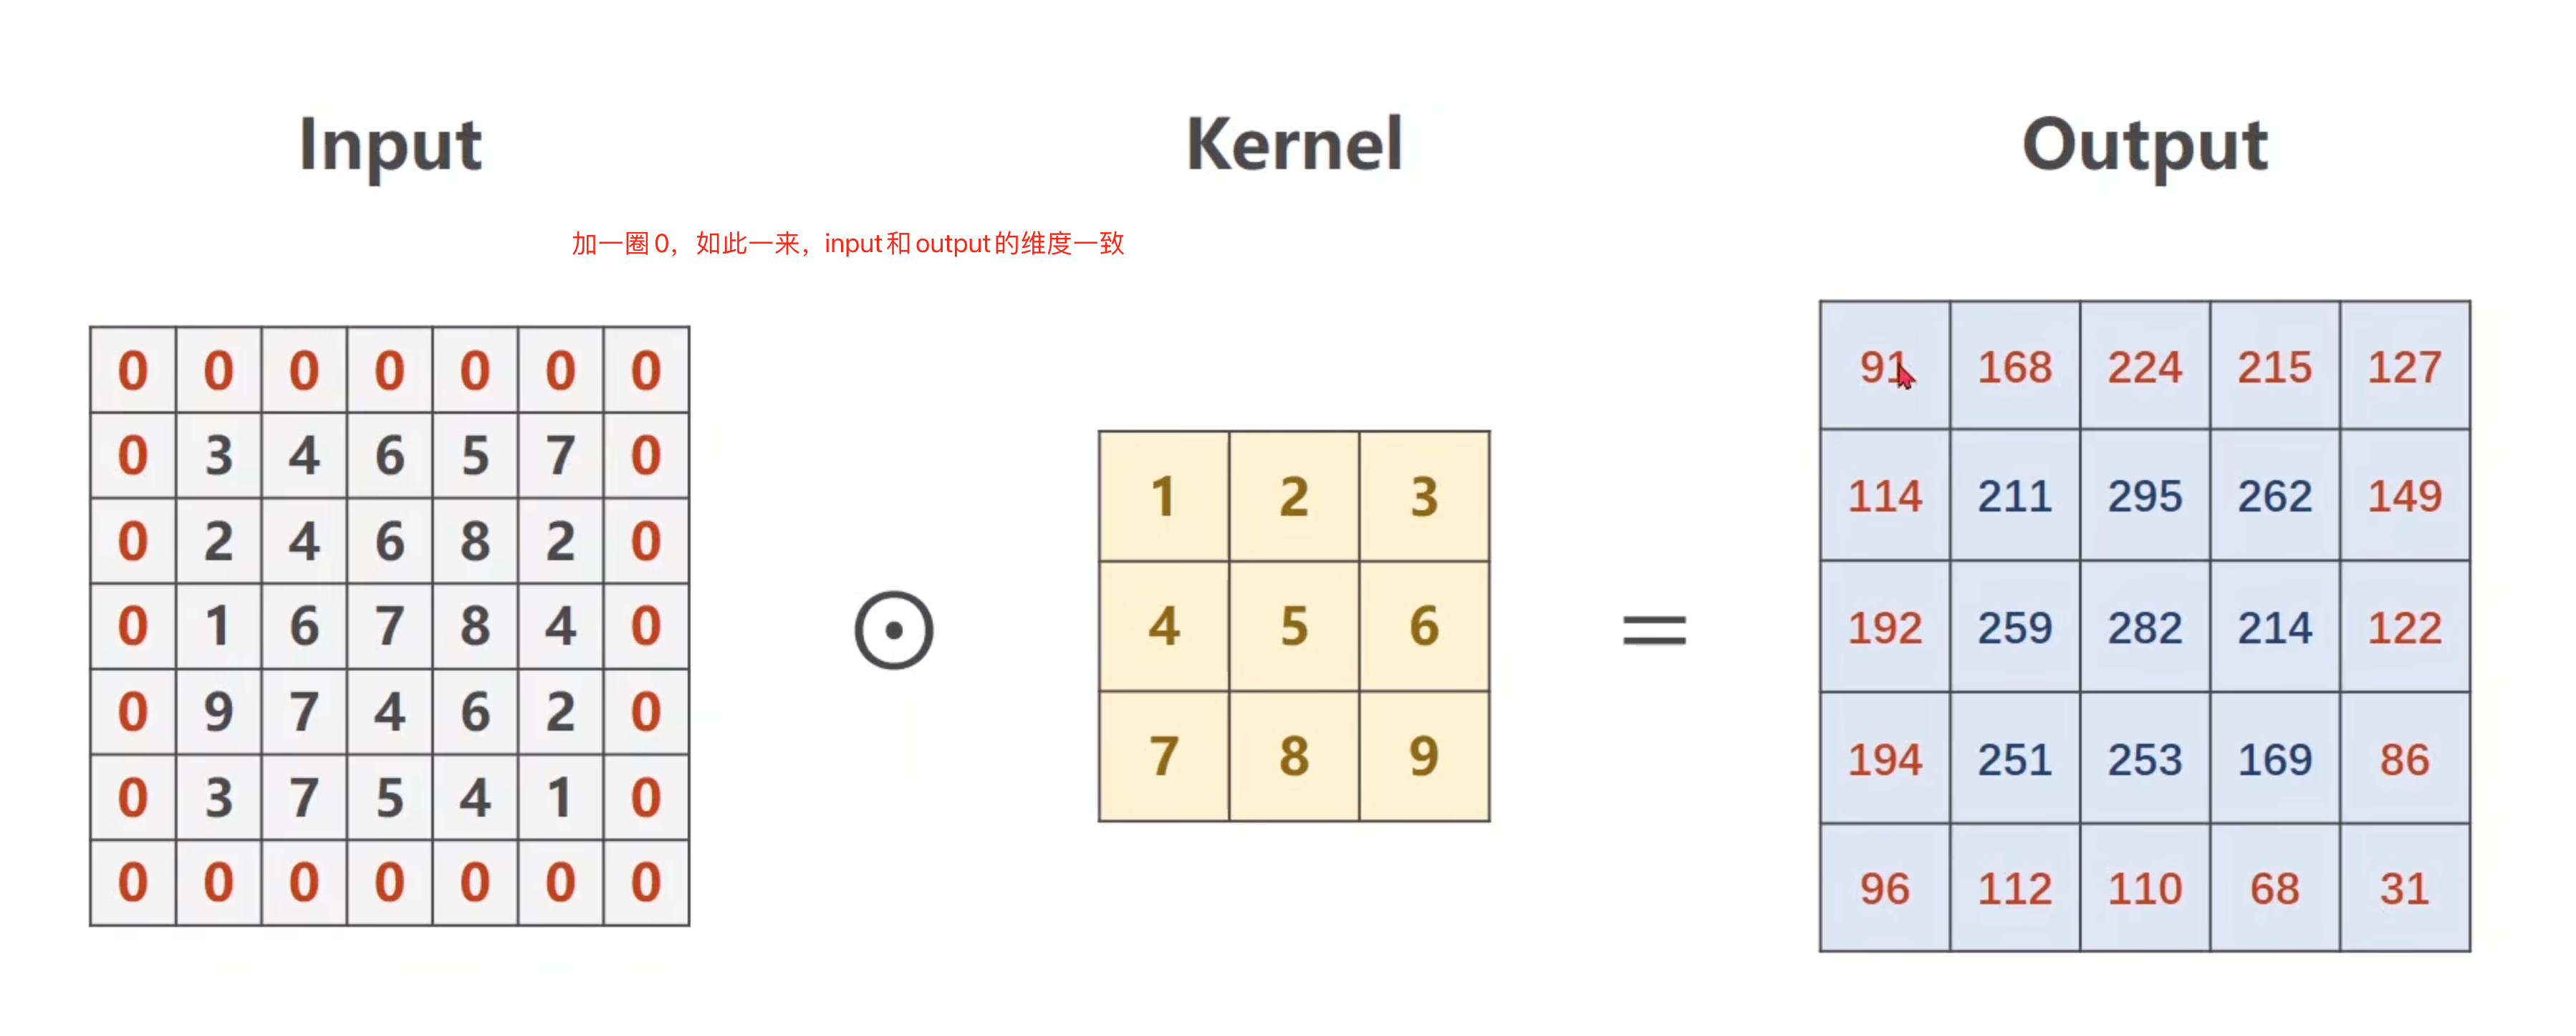

In [2]:
import torch 

input = [3,4,5,6,7,
         2,3,4,5,6,
         1,2,3,4,5,
         0,1,2,3,4,
         0,1,2,3,4,]

input = torch.Tensor(input).view(1,1,5,5) # b=1,c=1,h=5,w=5

conv = torch.nn.Conv2d(1,1,kernel_size=3,padding=1,bias=False)

kernel = torch.Tensor([1,2,3,4,5,6,7,8,9]).view(1,1,3,3) # output_channel=1,input_channel=1,kernel_size=3,3

conv.weight = torch.nn.Parameter(kernel)

output = conv(input)

print(output.shape) # 1,1,5,5
print(output)

torch.Size([1, 1, 5, 5])
tensor([[[[ 82., 136., 175., 214., 142.],
          [ 72., 123., 168., 213., 138.],
          [ 39.,  78., 123., 168., 111.],
          [ 23.,  57., 102., 147.,  99.],
          [  9.,  25.,  46.,  67.,  43.]]]], grad_fn=<ConvolutionBackward0>)


# stride：有效降低宽度和高度

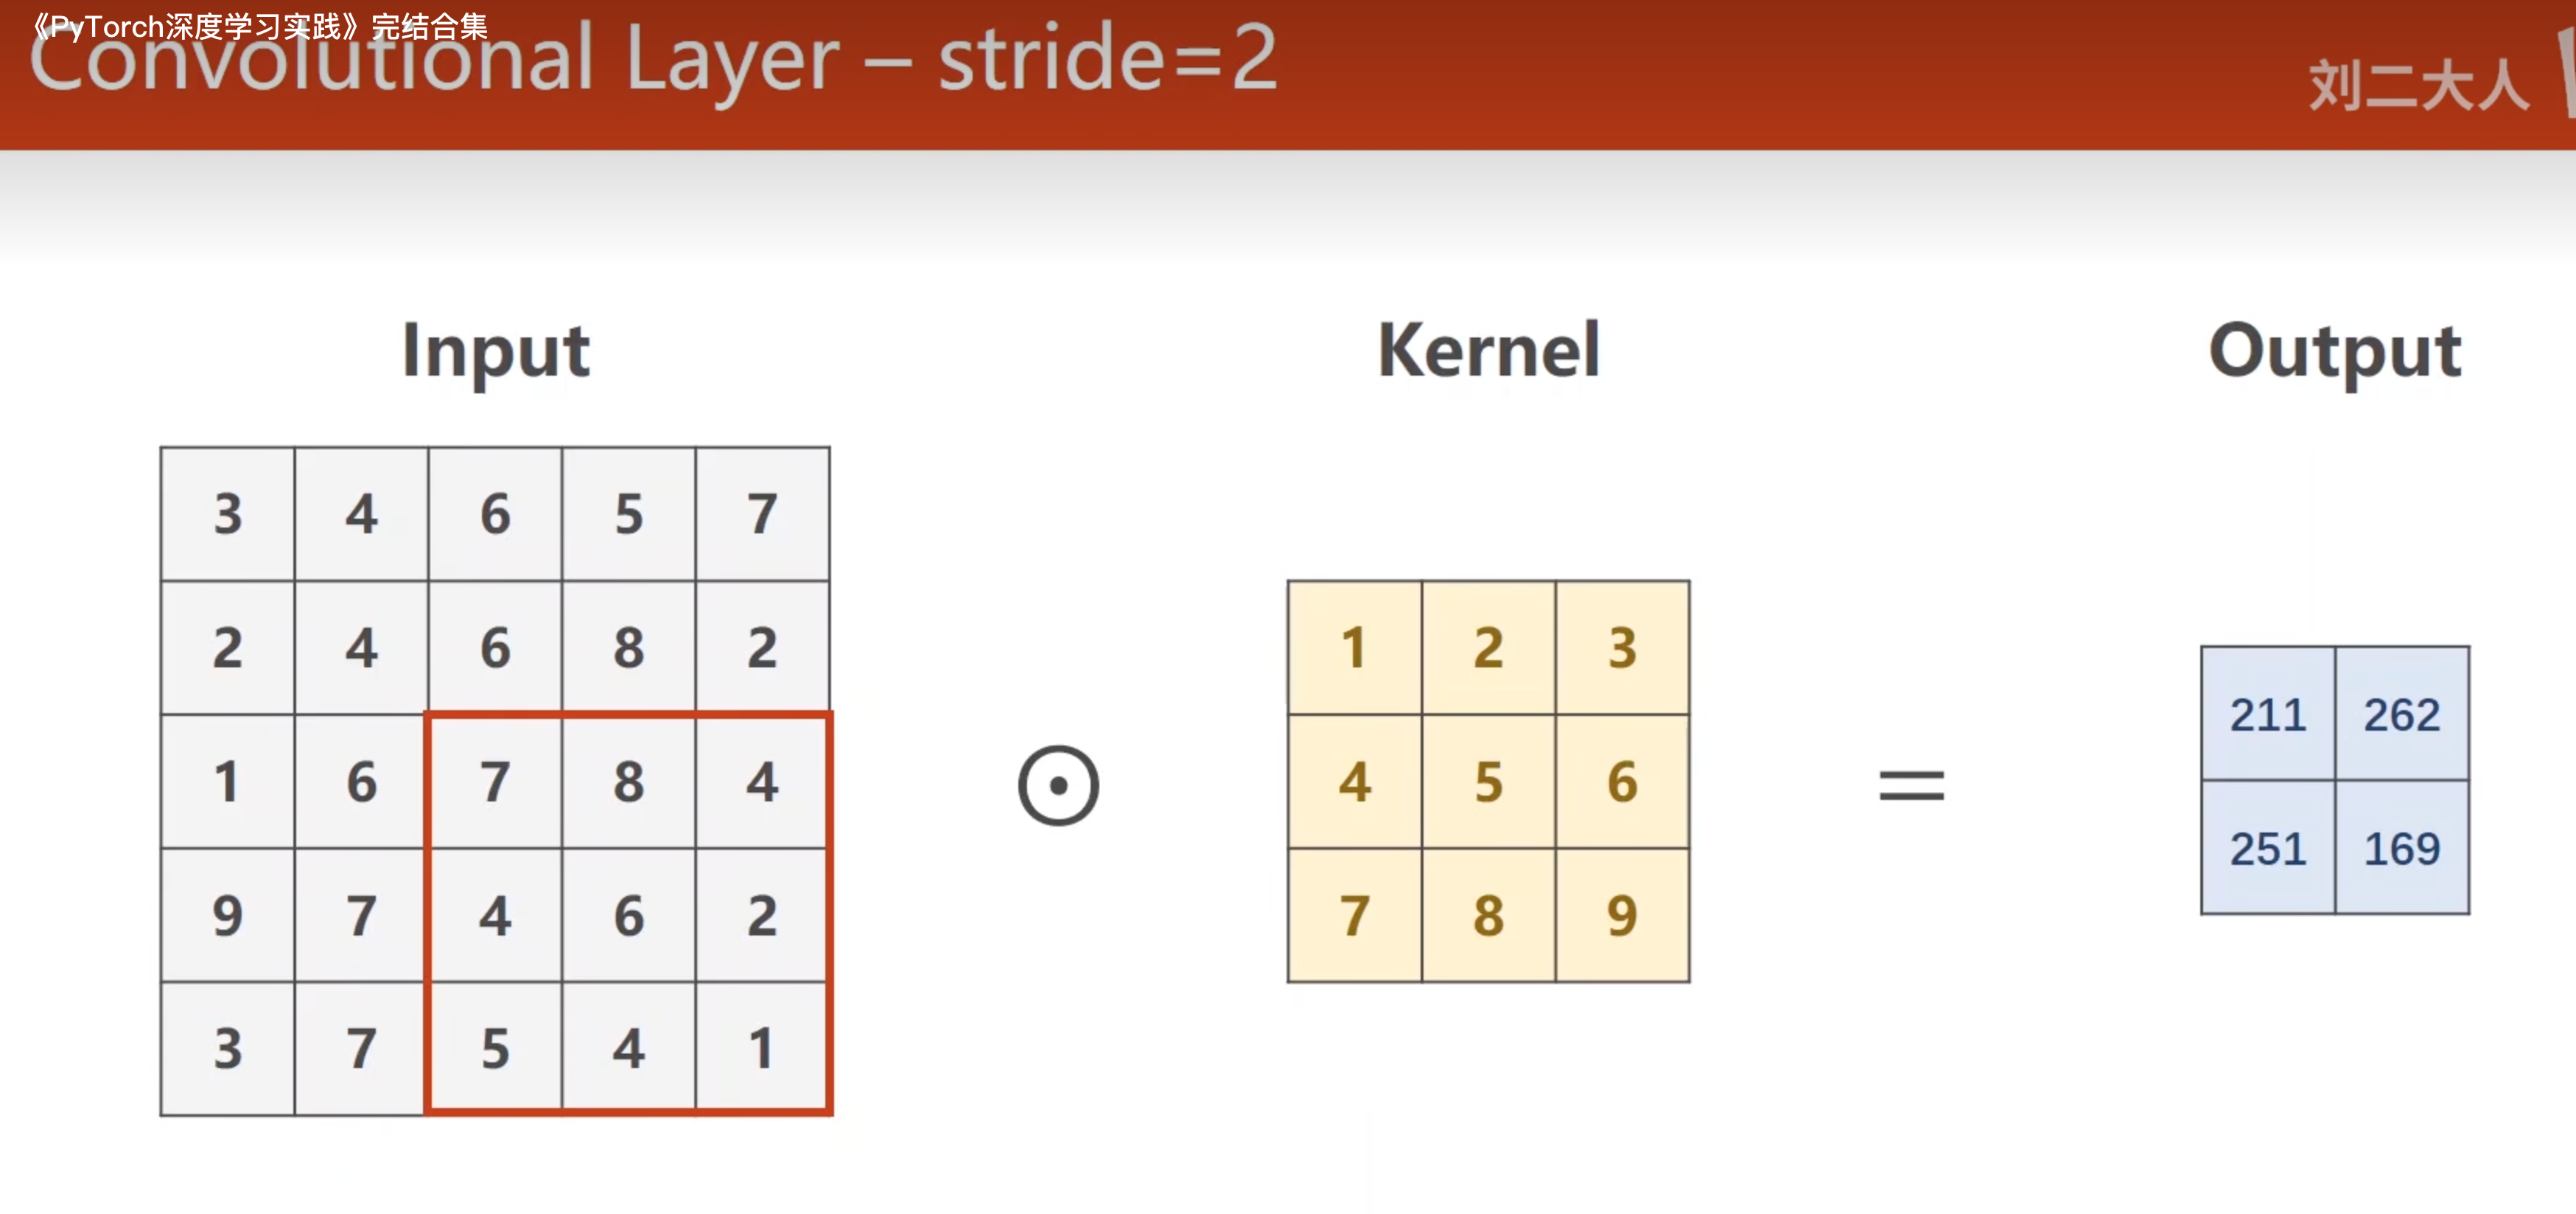

In [3]:
import torch 

input = [3,4,6,5,7,
         2,4,6,8,2,
         1,6,7,8,4,
         9,7,4,6,2,
         3,7,5,4,1]

input = torch.Tensor(input).view(1,1,5,5) # b=1,c=1,h=5,w=5

conv = torch.nn.Conv2d(1,1,kernel_size=3,stride=2,bias=False)

kernel = torch.Tensor([1,2,3,4,5,6,7,8,9]).view(1,1,3,3) # output_channel=1,input_channel=1,kernel_size=3,3

conv.weight = torch.nn.Parameter(kernel)

output = conv(input)

print(output.shape) # 1,1,2,2
print(output)

torch.Size([1, 1, 2, 2])
tensor([[[[211., 262.],
          [251., 169.]]]], grad_fn=<ConvolutionBackward0>)


# max pooling layer : 最大值采样

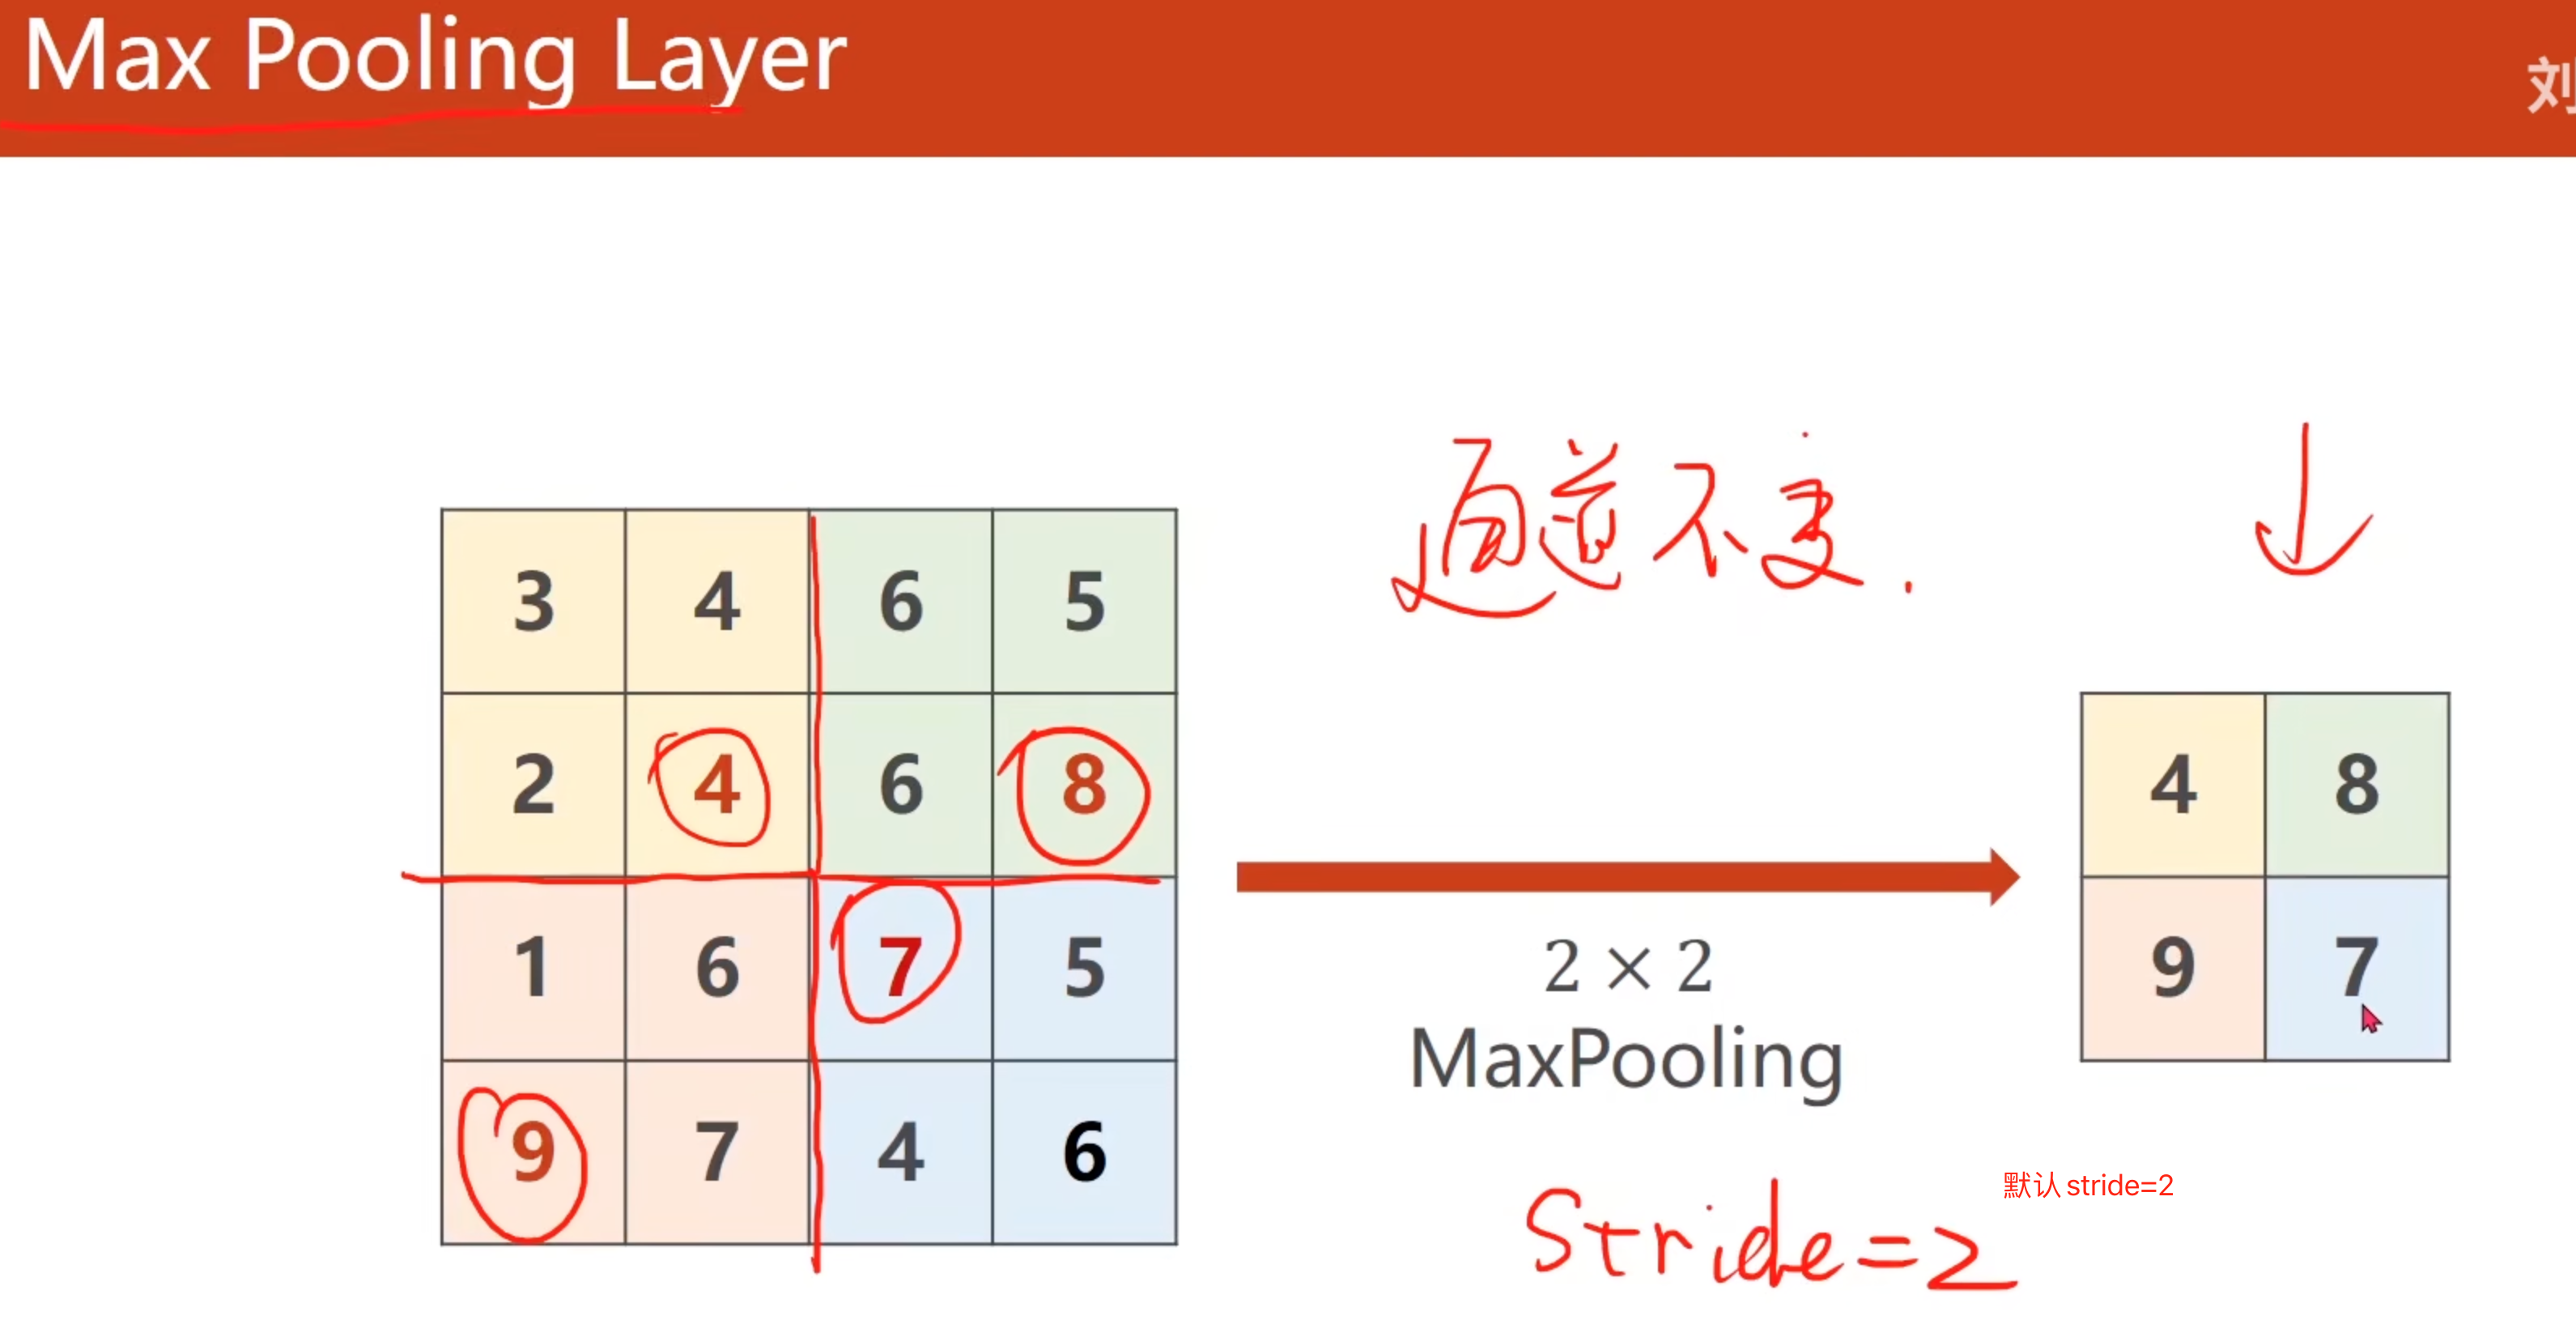

 import torch 

input = [3,4,6,5,
         2,4,6,8,
         1,6,7,5,
         9,7,4,6]

input = torch.Tensor(input).view(1,1,4,4) # b=1,c=1,h=4,w=4

pool = torch.nn.MaxPool2d(kernel_size=2,stride=2)

output = pool(input)

print(output.shape) # 1,1,2,2
print(output)

# A simple CNN

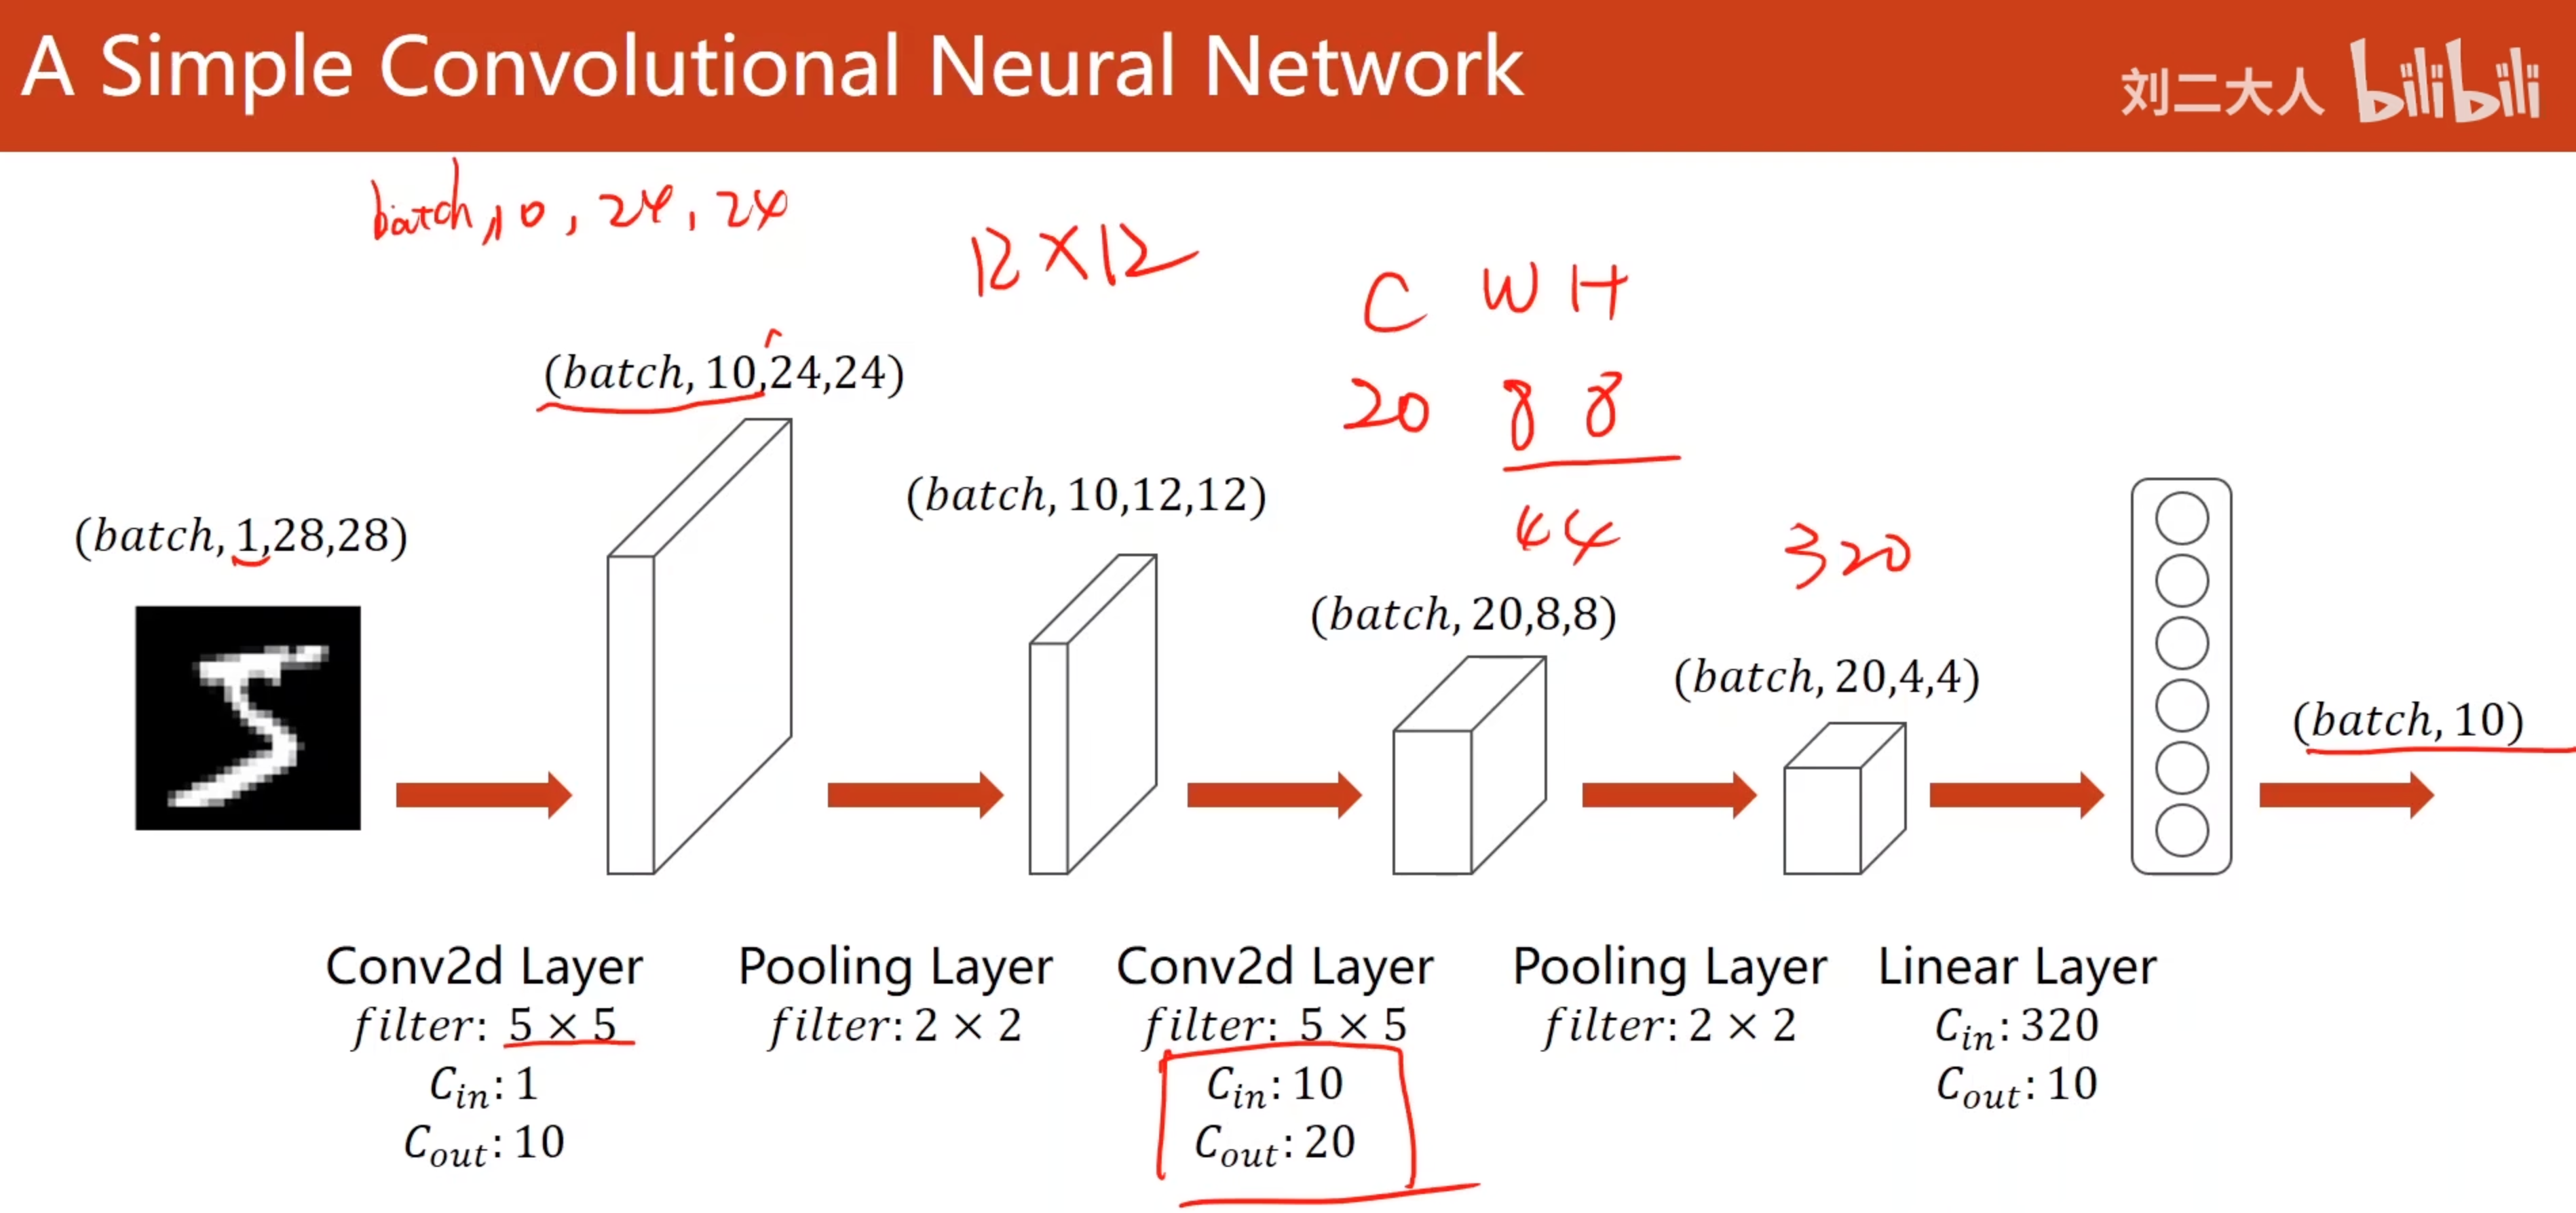

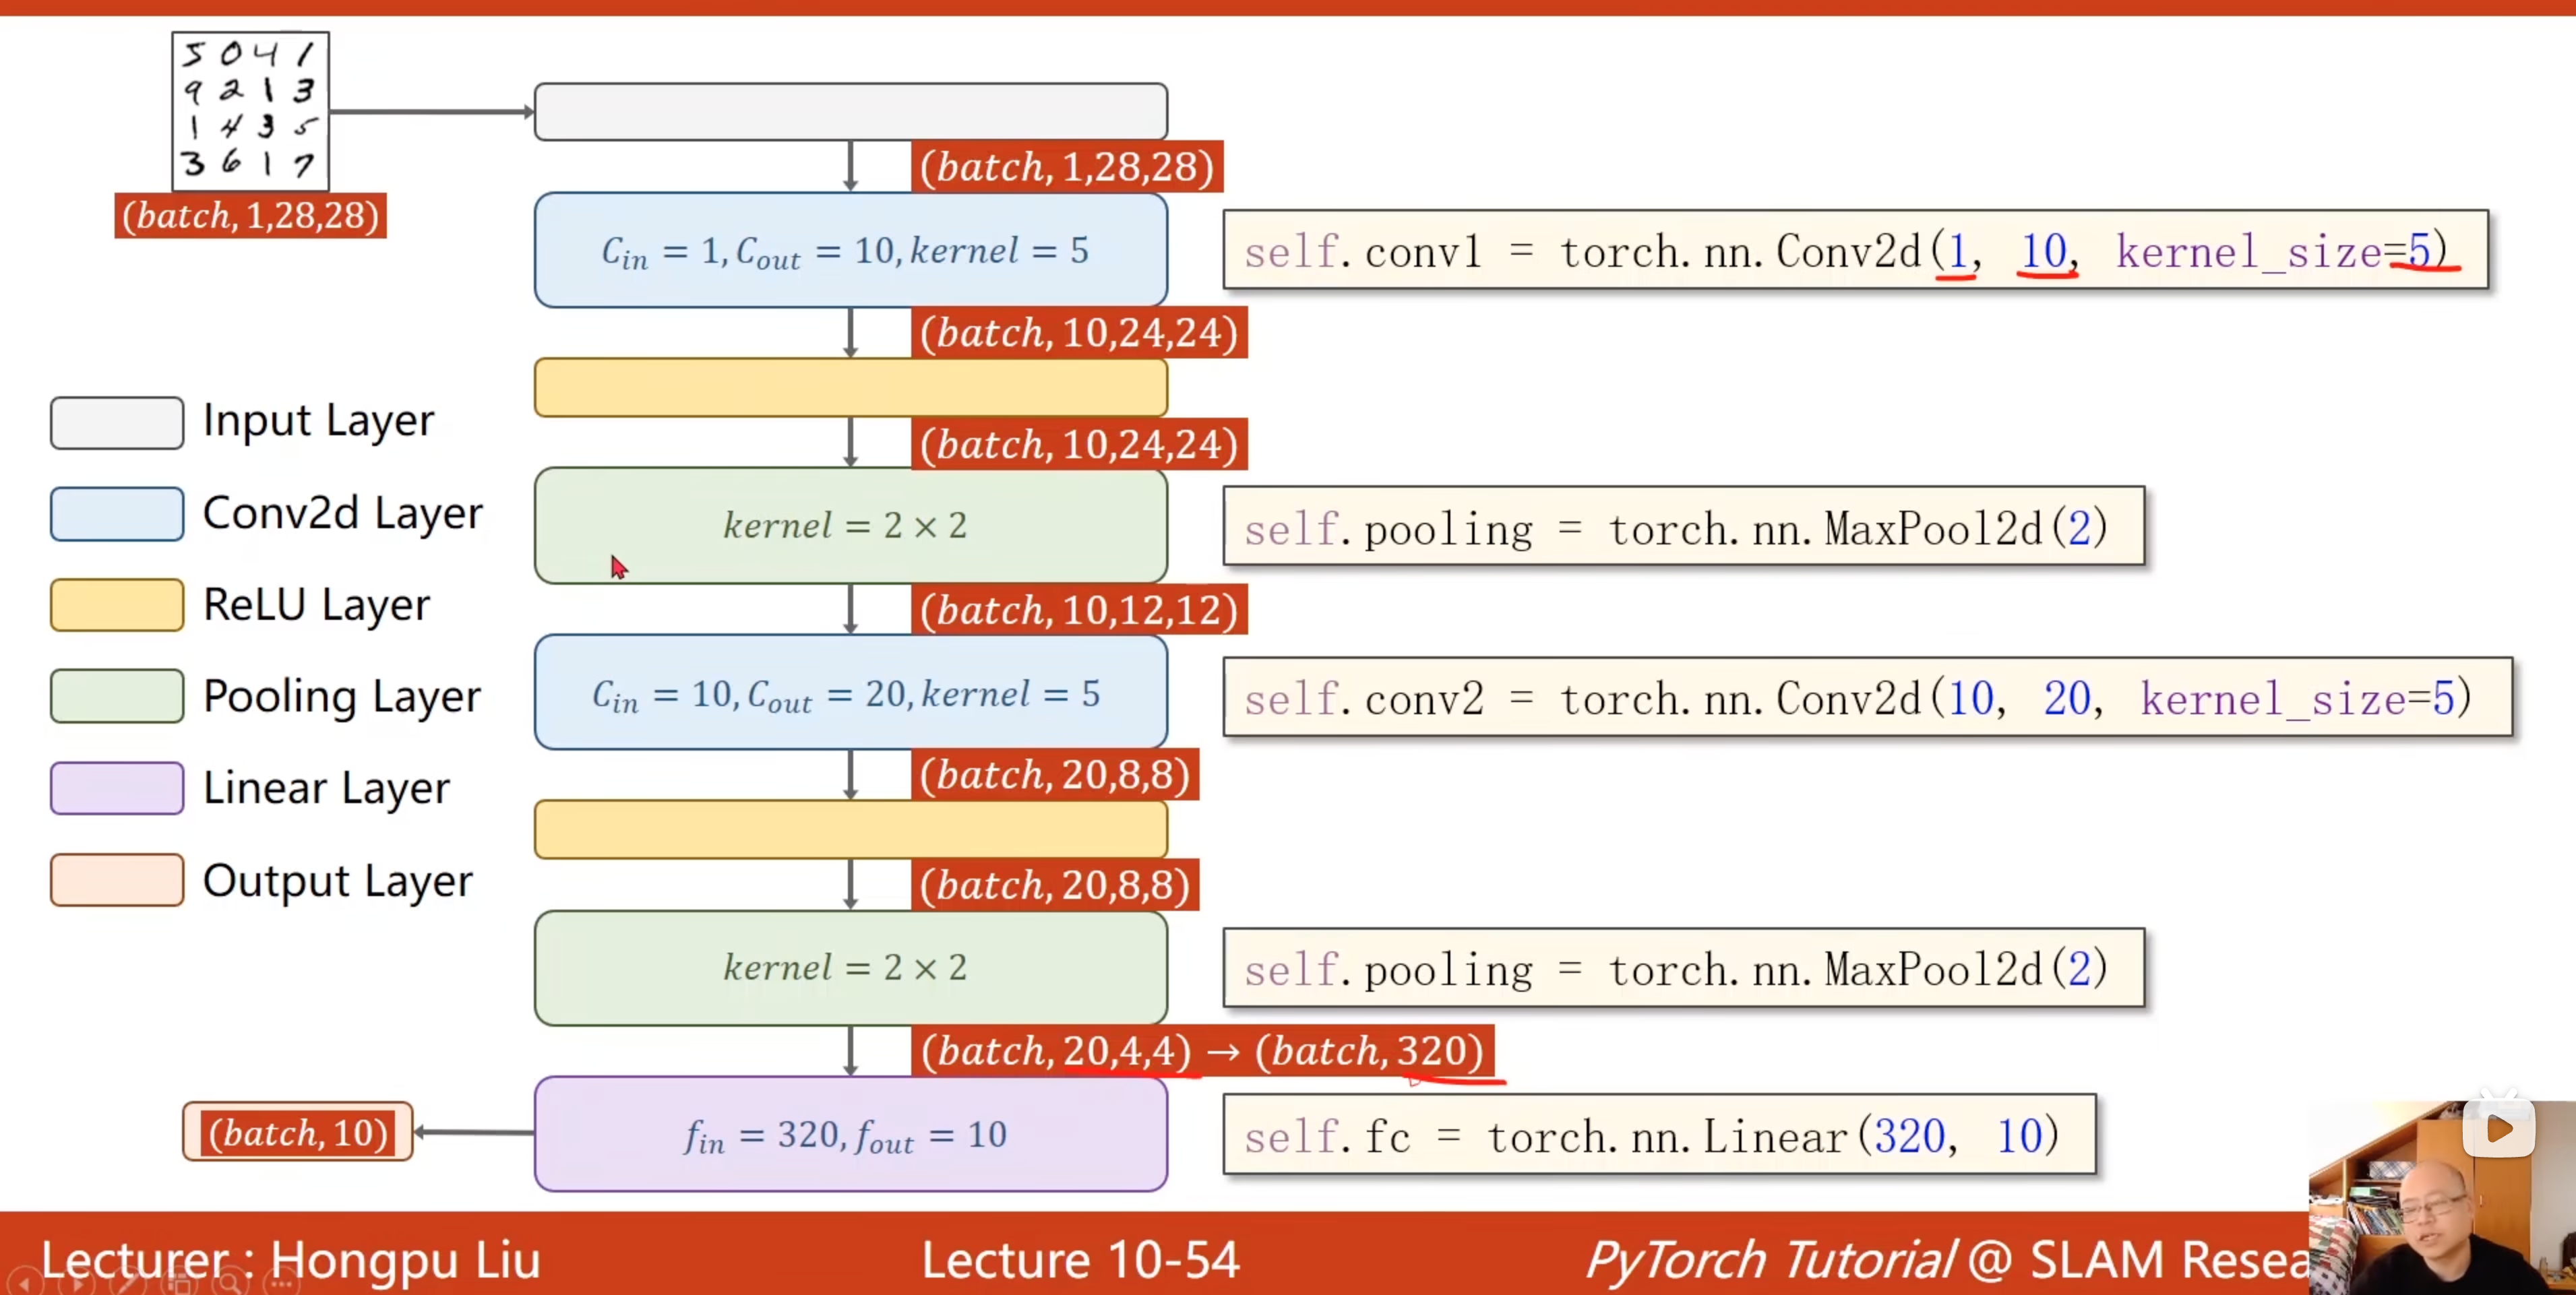

In [6]:
# design a simple CNN

import torch 
import torch.nn.functional as F
class SimpleCNN(torch.nn.Module):
    def __init__(self):
        super(SimpleCNN,self).__init__()
        self.conv1 = torch.nn.Conv2d(1,10,kernel_size=5)
        self.pool = torch.nn.MaxPool2d(2,2)
        self.conv2 = torch.nn.Conv2d(10,20,kernel_size=5)
        self.fc = torch.nn.Linear(20*4*4,10)

    def forward(self,x):
        # flatten data from (batch_size,1,28,28) to (batch_size,1*28*28)
        batch_size = x.size(0)

        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)

        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)

        x = x.view(batch_size, -1)
        x = self.fc(x)  
        return x

model = SimpleCNN()

In [7]:
import torch 
from torchvision import transforms,datasets
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.optim as optim

batch_size = 64 

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.1307,),(0.3081,)) # mean and std to 标准化:x-mu/std
])

train_dataset = datasets.MNIST(root='./dataset/mnist',train=True,download=True,transform=transform)
test_dataset = datasets.MNIST(root='./dataset/mnist',train=False,download=True,transform=transform)

train_loader = DataLoader(dataset=train_dataset,batch_size=batch_size,shuffle=True)
test_loader = DataLoader(dataset=test_dataset,batch_size=batch_size,shuffle=False)

criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),lr=0.01,momentum=0.5)

def train(epoch):
    running_loss = 0.0
    for batch_idx,data in enumerate(train_loader,0):
        inputs,target = data 
        optimizer.zero_grad()

        # forward
        outputs = model(inputs)
        loss = criterion(outputs,target)
        # backward
        loss.backward()
        # update
        optimizer.step()

        running_loss += loss.item()
        if batch_idx % 300 == 299:
            print('[%d,%5d] loss:%.3f' % (epoch+1,batch_idx+1,running_loss/300))
            running_loss = 0.0

def test():
    correct = 0
    total = 0
    with torch.no_grad(): # 测试时不需要计算梯度
        for data in test_loader:
            images,labels = data 
            outputs = model(images)

            # 返回最大值和最大值的索引，最大值即意味着预测的数字
            _,predicted = torch.max(outputs.data,dim=1) 
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print('Accuracy on test set: %d %%' % (100*correct/total))

In [8]:
if __name__ == '__main__':
    for epoch in range(10):
        train(epoch)
        test()

[1,  300] loss:0.654
[1,  600] loss:0.195
[1,  900] loss:0.144
Accuracy on test set: 96 %
[2,  300] loss:0.116
[2,  600] loss:0.101
[2,  900] loss:0.090
Accuracy on test set: 97 %
[3,  300] loss:0.082
[3,  600] loss:0.074
[3,  900] loss:0.075
Accuracy on test set: 98 %
[4,  300] loss:0.064
[4,  600] loss:0.064
[4,  900] loss:0.063
Accuracy on test set: 98 %
[5,  300] loss:0.060
[5,  600] loss:0.055
[5,  900] loss:0.053
Accuracy on test set: 98 %
[6,  300] loss:0.050
[6,  600] loss:0.049
[6,  900] loss:0.051
Accuracy on test set: 98 %
[7,  300] loss:0.047
[7,  600] loss:0.045
[7,  900] loss:0.044
Accuracy on test set: 98 %
[8,  300] loss:0.045
[8,  600] loss:0.039
[8,  900] loss:0.043
Accuracy on test set: 98 %
[9,  300] loss:0.041
[9,  600] loss:0.042
[9,  900] loss:0.032
Accuracy on test set: 98 %
[10,  300] loss:0.034
[10,  600] loss:0.039
[10,  900] loss:0.036
Accuracy on test set: 98 %
